Note: this analysis is for 15/28

## Get states for each work trajectory for N501Y

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller
import seaborn as sns


In [2]:
# Get dihedrals
def get_dihedrals(i, phase, outdir, htf, dihedral_indices_new):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
    modeller.deleteWater()
    new_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_forward = []
    all_pos_reverse = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_forward_neq_new.npy"), "rb") as f:
                all_pos_forward.append(np.load(f)[-1])
        except FileNotFoundError:
            pass
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_reverse_neq_new.npy"), "rb") as f:
                all_pos_reverse.append(np.load(f)[0])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_forward)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_forward), new_top)
    dihedrals_forward = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    traj = md.Trajectory(np.array(all_pos_reverse), new_top)
    dihedrals_reverse = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_forward, dihedrals_reverse

#### Get dihedrals for apo

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/28/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [4]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/data/chodera/zhangi/perses_benchmark/neq/15/28/28_apo.pickle'

In [ ]:
for atom in htf._topology_proposal.new_topology.atoms():
    if atom.residue.id == '501':
        print(atom)

In [ ]:
indices_new = [2605, 2607, 2609, 2612]
dihedrals_forward_apo, dihedrals_reverse_apo = get_dihedrals(i, phase, outdir, htf, indices_new)                                       


#### Get dihedrals for complex

In [8]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/15/28/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [9]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [10]:
for atom in htf._topology_proposal.new_topology.atoms():
    if atom.residue.id == '501':
        print(atom)

<Atom 2605 (N) of chain 0 residue 169 (TYR)>
<Atom 2606 (H) of chain 0 residue 169 (TYR)>
<Atom 2607 (CA) of chain 0 residue 169 (TYR)>
<Atom 2608 (HA) of chain 0 residue 169 (TYR)>
<Atom 2609 (CB) of chain 0 residue 169 (TYR)>
<Atom 2610 (HB2) of chain 0 residue 169 (TYR)>
<Atom 2611 (HB3) of chain 0 residue 169 (TYR)>
<Atom 2612 (CG) of chain 0 residue 169 (TYR)>
<Atom 2613 (CD1) of chain 0 residue 169 (TYR)>
<Atom 2614 (HD1) of chain 0 residue 169 (TYR)>
<Atom 2615 (CE1) of chain 0 residue 169 (TYR)>
<Atom 2616 (HE1) of chain 0 residue 169 (TYR)>
<Atom 2617 (CZ) of chain 0 residue 169 (TYR)>
<Atom 2618 (OH) of chain 0 residue 169 (TYR)>
<Atom 2619 (HH) of chain 0 residue 169 (TYR)>
<Atom 2620 (CE2) of chain 0 residue 169 (TYR)>
<Atom 2621 (HE2) of chain 0 residue 169 (TYR)>
<Atom 2622 (CD2) of chain 0 residue 169 (TYR)>
<Atom 2623 (HD2) of chain 0 residue 169 (TYR)>
<Atom 2624 (C) of chain 0 residue 169 (TYR)>
<Atom 2625 (O) of chain 0 residue 169 (TYR)>
<Atom 10909 (N) of chain 2 r

In [11]:
indices_new = [2605, 2607, 2609, 2612]
dihedrals_forward_complex, dihedrals_reverse_complex = get_dihedrals(i, phase, outdir, htf, indices_new)                                       


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


new files found: 87


In [12]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [14]:
# Create list of states for each work traj
# states_forward_apo = [get_state(angle) for angle in dihedrals_forward_apo]
# states_reverse_apo = [get_state(angle) for angle in dihedrals_reverse_apo]

states_forward_complex = [get_state(angle) for angle in dihedrals_forward_complex]
states_reverse_complex = [get_state(angle) for angle in dihedrals_reverse_complex]

In [15]:
# with open(os.path.join(outdir, "state_forward_apo.npy"), "wb") as f:
#     np.save(f, states_forward_apo)

# with open(os.path.join(outdir, "state_reverse_apo.npy"), "wb") as f:
#     np.save(f, states_reverse_apo)

with open(os.path.join(outdir, "state_forward_complex.npy"), "wb") as f:
    np.save(f, states_forward_complex)

with open(os.path.join(outdir, "state_reverse_complex.npy"), "wb") as f:
    np.save(f, states_reverse_complex)

/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  

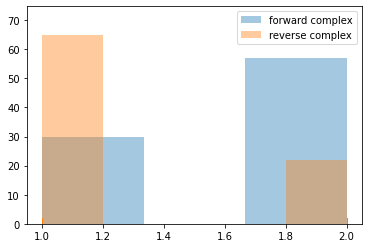

In [16]:
sns.distplot(states_forward_complex, label="forward complex", rug=True, kde=False)
sns.distplot(states_reverse_complex, label="reverse complex", rug=True, kde=False)
plt.legend()

## Run estimator on N501Y

In [17]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

INFO:numexpr.utils:Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [18]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [23]:
# Prep work arrays (from distributed jobs) and call analyze()
d_results = {}
d_phases = {}
first = 28
for i in tqdm_notebook([28]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/15/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/15/{i}/{i}_complex_{j}_reverse.npy'
#         forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/15/{i}/{i}_apo_{j}_forward.npy'
#         reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/15/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
#         if os.path.exists(forward_apo_path):
#             with open(forward_apo_path, 'rb') as f:
#                 array = np.load(f)
#                 forward_apo_arrays.append(array)
#                 print(array.shape)
#         if os.path.exists(reverse_apo_path):
#             with open(reverse_apo_path, 'rb') as f:
#                 array = np.load(f)
#                 print(array.shape)
#                 reverse_apo_arrays.append(array)


<ipython-input-23-dd950136b808>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([28]):


  0%|          | 0/1 [00:00<?, ?it/s]

dir: 28
job: 0
(1, 250001)
(1, 250001)
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
job: 18
(1, 250001)
(1, 250001)
job: 19
(1, 250001)
(1, 250001)
job: 20
(1, 250001)
(1, 250001)
job: 21
(1, 250001)
(1, 250001)
job: 22
(1, 250001)
(1, 250001)
job: 23
job: 24
(1, 250001)
(1, 250001)
job: 25
(1, 250001)
(1, 250001)
job: 26
(1, 250001)
(1, 250001)
job: 27
(1, 250001)
(1, 250001)
job: 28
(1, 250001)
(1, 250001)
job: 29
(1, 250001)
(1, 250001)
job: 30
(1, 250001)
(1, 250001)
job: 31
(1, 250001)
(1, 250001)
job: 32
(1, 250001)
(1, 250001)
job: 33
(1, 250001)
(1, 250001)
job: 34
(1, 250001)
(1, 250001)
job: 35
(1, 250001)
(1, 250001)
job: 36
(1, 250001)
(1, 250001)
job: 37
(1, 250001)
(1, 250001)
job: 38
(1, 250001)
(1, 250001)
job: 39
(1, 250001

In [24]:
if forward_complex_arrays and reverse_complex_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
#     forward_apo_combined = np.concatenate(forward_apo_arrays)
#     forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
# #     forward_apo_accumulated = [val for val in forward_apo_accumulated if not math.isnan(val)]
    
#     reverse_apo_combined = np.concatenate(reverse_apo_arrays)
#     reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
# #     reverse_apo_accumulated = [val for val in reverse_apo_accumulated if not math.isnan(val)]
    
    # Prep input for estimator
    d_input_works = {}
    d_input_works['apo'] = {}
    d_input_works['complex'] = {}
    d_input_works['apo']['forward'], d_input_works['apo']['reverse'] = dict(), dict()
    d_input_works['complex']['forward'], d_input_works['complex']['reverse'] = dict(), dict()
    
    # Create lists for each state
    n_states = 3
    for i in range(n_states):
        d_input_works['apo']['forward'][i] = list()
        d_input_works['apo']['reverse'][i] = list()
        d_input_works['complex']['forward'][i] = list()
        d_input_works['complex']['reverse'][i] = list()
    
#     n_cycles_apo = len(forward_apo_arrays)
#     for i in range(n_cycles_apo):
#         state_forward = states_forward_apo[i]
#         state_reverse = states_reverse_apo[i]
#         d_input_works['apo']['forward'][state_forward].append(forward_apo_accumulated[i])
#         d_input_works['apo']['reverse'][state_reverse].append(reverse_apo_accumulated[i])
        
    n_cycles_complex = len(forward_complex_arrays)
    for i in range(n_cycles_complex):
        state_forward = states_forward_complex[i]
        state_reverse = states_reverse_complex[i]
        d_input_works['complex']['forward'][state_forward].append(forward_complex_accumulated[i])
        d_input_works['complex']['reverse'][state_reverse].append(reverse_complex_accumulated[i])

#     # Plot work distributions
#     for i in [1]:
#         sns.distplot(np.array(d_input_works['apo']['forward'][i]), label=f"state{i}f")
#         sns.distplot(np.array(d_input_works['apo']['reverse'][i])*-1, label=f"state{i}r")
#     plt.xlabel("work (kT)")
#     plt.ylabel("p(w)")
#     plt.legend()
#     plt.show()
# #     plt.title(f"{title} {phase}")
# #     plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
# #     print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
# #     plt.clf()    
else:
    print(f"dir {i} has at least one phase without data" )

/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

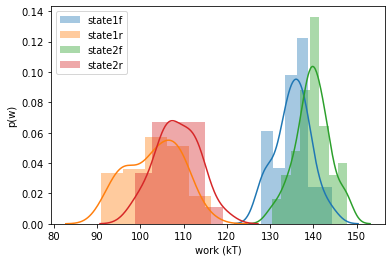

In [25]:
# Plot work distributions
plt.clf()
for i in [1, 2]:
    sns.distplot(np.array(d_input_works['complex']['forward'][i]), label=f"state{i}f")
    sns.distplot(np.array(d_input_works['complex']['reverse'][i])*-1, label=f"state{i}r")
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.legend()
plt.show()